In [2]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import concurrent.futures
from tqdm.notebook import tqdm


# Authenticate with W&B
wandb.login(timeout=128)

# Configure project and other parameters if necessary
project_name = "contrastive_exploration"
entity = "pletctj6"

# Retrieve the runs from the project
api = wandb.Api()
runs = api.runs(f"{entity}/{project_name}")

# Initialize a list to store coverage and shannon entropy data
experiments_data = {}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pletctj6. Use `wandb login --relogin` to force relogin


### Downloading the data

In [2]:
def process_run(run):
    # Vérification de l'état du run
    if run.state != "finished":
        # print(f"Skipping run {run.name} because it is not finished.")
        return None
    
    # Récupération de la configuration du run
    config = run.config
    exp_name = config.get('exp_name', 'unknown_exp')
    env_name = config.get('env_id', 'unknown_env')
    seed = config.get('seed', 'unknown_seed')
    keep_extrinsic_reward = config.get('keep_extrinsic_reward', False)
    beta_ratio = config.get('beta_ratio', None)
    use_sigmoid = config.get('use_sigmoid', None)
    feature_extractor = config.get('feature_extractor', None)
    history = run.history()
    
    # Vérification de la présence des colonnes nécessaires dans l'historique
    if "specific/coverage" not in history.columns or "specific/shanon_entropy" not in history.columns or "global_step" not in history.columns:
        # print(f"Skipping run {exp_name} - {env_name} - {seed} because it doesn't have all the necessary data.")
        return None
    
    coverage_evolution = history['specific/coverage']
    shannon_entropy_evolution = history['specific/shanon_entropy']
    global_step_evolution = history['global_step']

    # Vérification de la présence des valeurs finales nécessaires
    if "specific/coverage" not in run.summary or "specific/shanon_entropy" not in run.summary or "global_step" not in run.summary:
        # print(f"Skipping run {exp_name} - {env_name} - {seed} because it doesn't have all the necessary data.")
        return None
    
    final_coverage = run.summary['specific/coverage']
    final_shannon_entropy = run.summary['specific/shanon_entropy']
    final_global_step = run.summary['global_step']

    # Retour des données structurées
    return {
        'exp_name': exp_name,
        'env_name': env_name,
        'seed': seed,
        'data': {
            "keep_extrinsic_reward": keep_extrinsic_reward,
            "coverage": coverage_evolution,
            "shannon_entropy": shannon_entropy_evolution,
            "final_coverage": final_coverage,
            "final_shannon_entropy": final_shannon_entropy,
            "global_step": global_step_evolution,
            "final_global_step": final_global_step,
            "beta_ratio": beta_ratio,
            "use_sigmoid": use_sigmoid, 
            "feature_extractor": feature_extractor,
            'config': config
        }
    }

experiments_data = {}
max_workers = 8
# Utilisation de ThreadPoolExecutor pour paralléliser les exécutions de runs
# Spécifiez le nombre de threads avec max_workers, par exemple 4 threads
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(process_run, run): run for run in runs}
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing runs"):
        result = future.result()
        if result is not None:
            exp_name = result['exp_name']
            env_name = result['env_name']
            seed = result['seed']
            data = result['data']

            if exp_name not in experiments_data:
                experiments_data[exp_name] = {}
            if env_name not in experiments_data[exp_name]:
                experiments_data[exp_name][env_name] = {}
            if seed not in experiments_data[exp_name][env_name]:
                experiments_data[exp_name][env_name][seed] = data

Processing runs:   0%|          | 0/1615 [00:00<?, ?it/s]

### Table final coverage

In [9]:
import pandas as pd
import numpy as np
from tabulate import tabulate

def extract_final_values(experiments_data):
    coverage_data = []
    entropy_data = []

    for exp_name in experiments_data.keys():
        for env_name in experiments_data[exp_name].keys():
            for seed in experiments_data[exp_name][env_name].keys():
                run_data = experiments_data[exp_name][env_name][seed]
                final_coverage = run_data['final_coverage']
                max_entropy = run_data['shannon_entropy'].max()
                coverage_data.append({
                    'exp_name': exp_name,
                    'env_name': env_name,
                    'seed': seed,
                    'coverage': final_coverage
                })
                entropy_data.append({
                    'exp_name': exp_name,
                    'env_name': env_name,
                    'seed': seed,
                    'shannon_entropy': max_entropy
                })
    
    coverage_df = pd.DataFrame(coverage_data)
    entropy_df = pd.DataFrame(entropy_data)
    return coverage_df, entropy_df

# Fonction pour normaliser le coverage par le coverage maximal de l'environnement
def normalize_coverage(coverage_df):
    coverage_df['coverage_max'] = coverage_df.groupby('env_name')['coverage'].transform('max')
    coverage_df['coverage_mean'] = coverage_df.groupby(['exp_name', 'env_name'])['coverage'].transform('mean')
    coverage_df['coverage_std'] = coverage_df.groupby(['exp_name', 'env_name'])['coverage'].transform('std')
    
    coverage_df['coverage_normalized_mean'] = (coverage_df['coverage_mean'] / coverage_df['coverage_max']) * 100
    coverage_df['coverage_normalized_std'] = (coverage_df['coverage_std'] / coverage_df['coverage_max']) * 100
    
    normalized_df = coverage_df[['exp_name', 'env_name', 'coverage_normalized_mean', 'coverage_normalized_std']].drop_duplicates()
    return normalized_df

# Fonction pour calculer la moyenne et l'écart type de l'entropie de Shannon
def calculate_entropy_stats(entropy_df):
    entropy_stats_df = entropy_df.groupby(['exp_name', 'env_name']).agg(
        shannon_entropy_mean=('shannon_entropy', 'mean'),
        shannon_entropy_std=('shannon_entropy', 'std')
    ).reset_index()
    return entropy_stats_df

# Fonction pour formater les résultats dans le format souhaité
def format_results(df, value_col_mean, value_col_std):
    formatted_results = df.pivot(index='exp_name', columns='env_name', values=[value_col_mean, value_col_std])
    formatted_results = formatted_results.swaplevel(axis=1).sort_index(axis=1, level=0)
    for env in formatted_results.columns.levels[0]:
        formatted_results[(env, 'mean +/- std')] = formatted_results[(env, value_col_mean)].round(2).astype(str) + " +/- " + formatted_results[(env, value_col_std)].round(2).astype(str)
    formatted_results = formatted_results.loc[:, pd.IndexSlice[:, 'mean +/- std']]
    formatted_results.columns = formatted_results.columns.droplevel(1)
    return formatted_results

# Fonction pour convertir les DataFrames en tableaux Markdown
def dataframe_to_markdown(df, filename):
    markdown_table = tabulate(df, headers='keys', tablefmt='pipe', showindex=True)
    with open(filename, 'w') as f:
        f.write(markdown_table)

# Extraction des valeurs finales
coverage_df, entropy_df = extract_final_values(experiments_data)

# Normalisation du coverage et calcul des statistiques de l'entropie de Shannon
coverage_normalized_df = normalize_coverage(coverage_df)
entropy_stats_df = calculate_entropy_stats(entropy_df)

# Formater les résultats
coverage_formatted = format_results(coverage_normalized_df, 'coverage_normalized_mean', 'coverage_normalized_std')
entropy_formatted = format_results(entropy_stats_df, 'shannon_entropy_mean', 'shannon_entropy_std')

# Enregistrement des DataFrames au format Markdown
dataframe_to_markdown(coverage_formatted, 'coverage_normalized.md')
dataframe_to_markdown(entropy_formatted, 'shannon_entropy.md')

# Affichage des résultats
print("Coverage Normalized DataFrame:")
print(tabulate(coverage_formatted, headers='keys', tablefmt='pipe', showindex=True))

print("\nShannon Entropy DataFrame:")
print(tabulate(entropy_formatted, headers='keys', tablefmt='pipe', showindex=True))


Coverage Normalized DataFrame:
| exp_name                          | Ant-v3          | DMCS-Acrobot-v0   | DMCS-Ball-in-cup-v0   | DMCS-Cart-k-Pole-v0   | DMCS-Finger-v0   | DMCS-Fish-v0    | FetchPush-v2    | FetchReach-v1   | FetchSlide-v2   | HalfCheetah-v3   | Hopper-v3       | Humanoid-v3    | HumanoidStandup-v4   | Maze-Easy-v0    | Maze-Hard-v0    | Maze-Ur-v0      | Reacher-v4     | Swimmer-v3      | Walker2d-v3     |
|:----------------------------------|:----------------|:------------------|:----------------------|:----------------------|:-----------------|:----------------|:----------------|:----------------|:----------------|:-----------------|:----------------|:---------------|:---------------------|:----------------|:----------------|:----------------|:---------------|:----------------|:----------------|
| apt_ppo                           | 85.07 +/- 8.12  | 44.75 +/- 2.65    | 69.82 +/- 6.98        | 50.34 +/- 6.79        | 54.02 +/- 4.99   | 50.63 +/- 7.06  | 96.13 +/- 

### Data cleaning

In [ ]:


# Fonction pour vérifier si une liste est vide
def is_not_empty(obj):
    if isinstance(obj, pd.Series):
        return not obj.empty
    return bool(obj)

def interpolate_and_fill_single_metric(values, global_steps, max_global_step):
    values = values.dropna()
    # Créer une série avec des NaNs pour les global_steps manquants
    all_steps = np.arange(max_global_step + 1)
    series = values.reindex(all_steps).interpolate(method='linear').ffill().bfill()
    return series

# Convertir le dictionnaire en DataFrame avec calcul des statistiques directement
def dict_to_dataframe(experiments_data, data_keys=['coverage', 'shannon_entropy', 'global_step']):
    data_records = []

    # Déterminer le global_step maximum pour chaque environnement
    max_global_steps = {}
    for exp_name in experiments_data.keys():
        for env_name in experiments_data[exp_name].keys():
            for seed in experiments_data[exp_name][env_name].keys():
                max_global_step = experiments_data[exp_name][env_name][seed]['final_global_step']
                if env_name not in max_global_steps:
                    max_global_steps[env_name] = max_global_step
                else:
                    max_global_steps[env_name] = max(max_global_steps[env_name], max_global_step)

    # Compter le nombre total de runs pour la barre de progression
    total_runs = sum(len(experiments_data[exp_name][env_name]) for exp_name in experiments_data for env_name in experiments_data[exp_name])

    with tqdm(total=total_runs, desc="Processing runs") as pbar:
        for exp_name in experiments_data.keys():
            for env_name in experiments_data[exp_name].keys():
                max_global_step = max_global_steps[env_name]
                env_records = []
                for seed in experiments_data[exp_name][env_name].keys():
                    data_global_step = experiments_data[exp_name][env_name][seed]['global_step']
                    for data_key in data_keys:
                        if data_key == 'global_step':
                            data_raw = data_global_step
                        else:
                            data_raw = experiments_data[exp_name][env_name][seed][data_key]

                        data_filtered = interpolate_and_fill_single_metric(data_raw, data_global_step, max_global_step)
                        temp_df = pd.DataFrame({
                            'exp_name': exp_name,
                            'env_name': env_name,
                            'seed': seed,
                            'global_step': data_filtered.index,
                            data_key: data_filtered.values
                        })
                        env_records.append(temp_df)
                    pbar.update(1)  # Mise à jour de la barre de progression pour chaque run

                if env_records:
                    combined_df = pd.concat(env_records, axis=0)
                    summary_df = combined_df.groupby(['exp_name', 'env_name', 'global_step']).agg(
                        coverage_mean=('coverage', 'mean'),
                        coverage_std=('coverage', 'std'),
                        shannon_entropy_mean=('shannon_entropy', 'mean'),
                        shannon_entropy_std=('shannon_entropy', 'std')
                    ).reset_index()
                    data_records.append(summary_df)

    final_df = pd.concat(data_records, axis=0)
    return final_df


# Créer le DataFrame
df = dict_to_dataframe(experiments_data)



### Plotting

coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499825,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499825,)


/home/p.le-tolguenec/Documents/contrastive_exploration/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


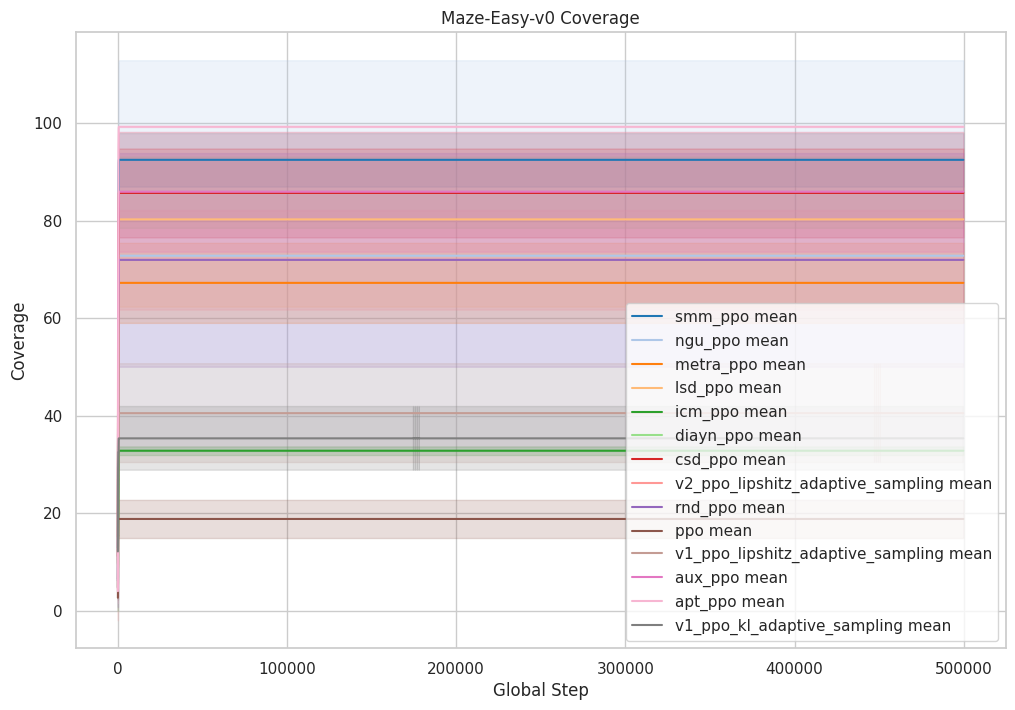

coverage mean shape (499745,)
coverage mean shape (499790,)
coverage mean shape (499745,)
coverage mean shape (499745,)
coverage mean shape (499803,)
coverage mean shape (499745,)
coverage mean shape (499745,)
coverage mean shape (499747,)
coverage mean shape (499804,)
coverage mean shape (499745,)
coverage mean shape (499821,)
coverage mean shape (499791,)
coverage mean shape (499797,)
coverage mean shape (499817,)


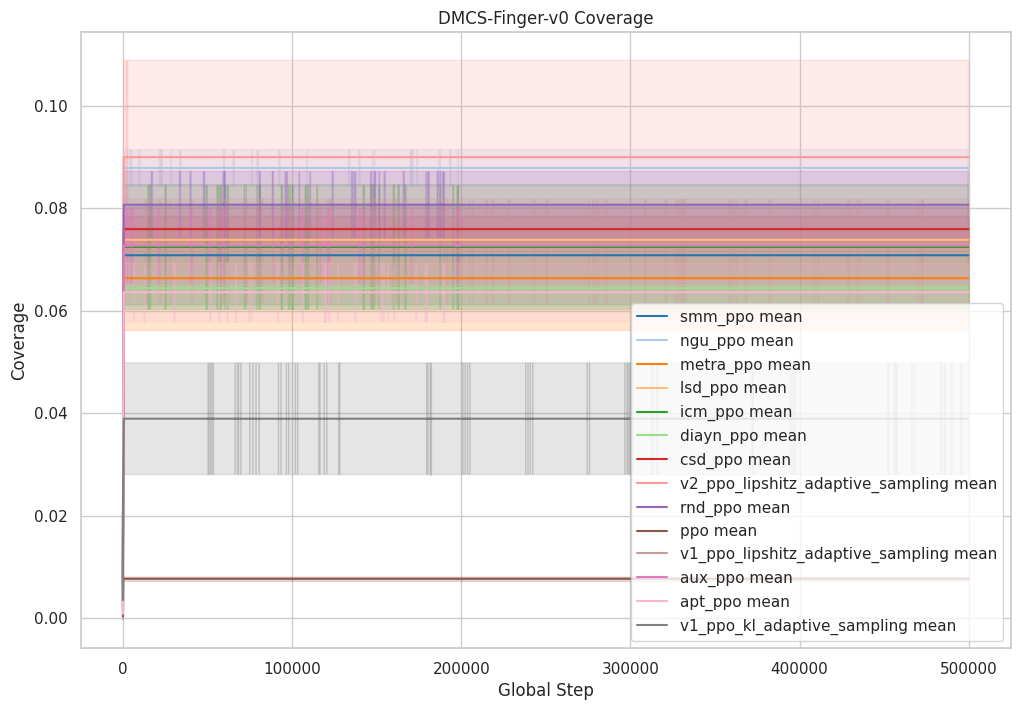

coverage mean shape (499745,)
coverage mean shape (499804,)
coverage mean shape (499745,)
coverage mean shape (499745,)
coverage mean shape (499824,)
coverage mean shape (499745,)
coverage mean shape (499745,)
coverage mean shape (499747,)
coverage mean shape (499813,)
coverage mean shape (499745,)
coverage mean shape (499806,)
coverage mean shape (499798,)
coverage mean shape (499819,)
coverage mean shape (499846,)


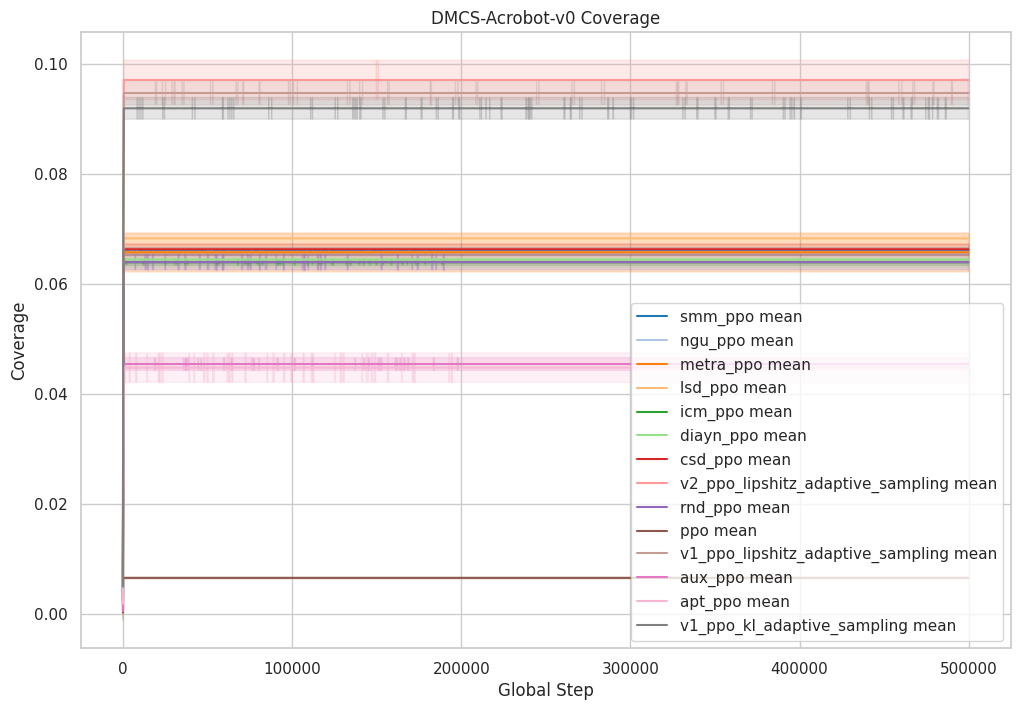

coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499823,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)


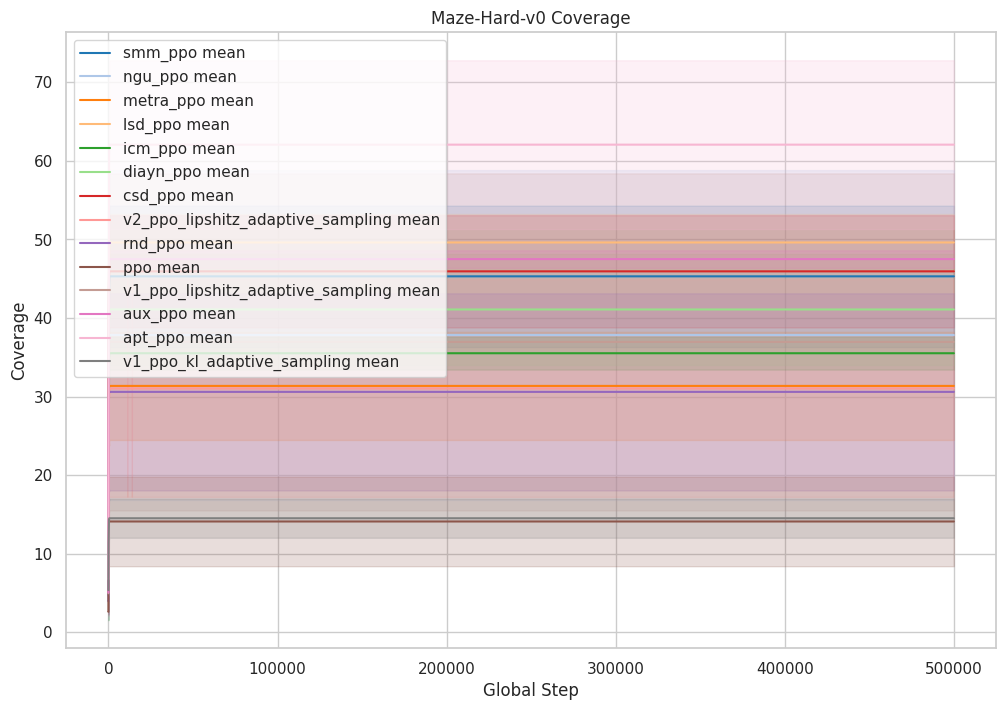

coverage mean shape (499799,)
coverage mean shape (499797,)
coverage mean shape (499803,)
coverage mean shape (499799,)
coverage mean shape (499801,)
coverage mean shape (499799,)
coverage mean shape (499807,)
coverage mean shape (499813,)
coverage mean shape (499797,)
coverage mean shape (499803,)
coverage mean shape (499801,)
coverage mean shape (499797,)
coverage mean shape (499797,)


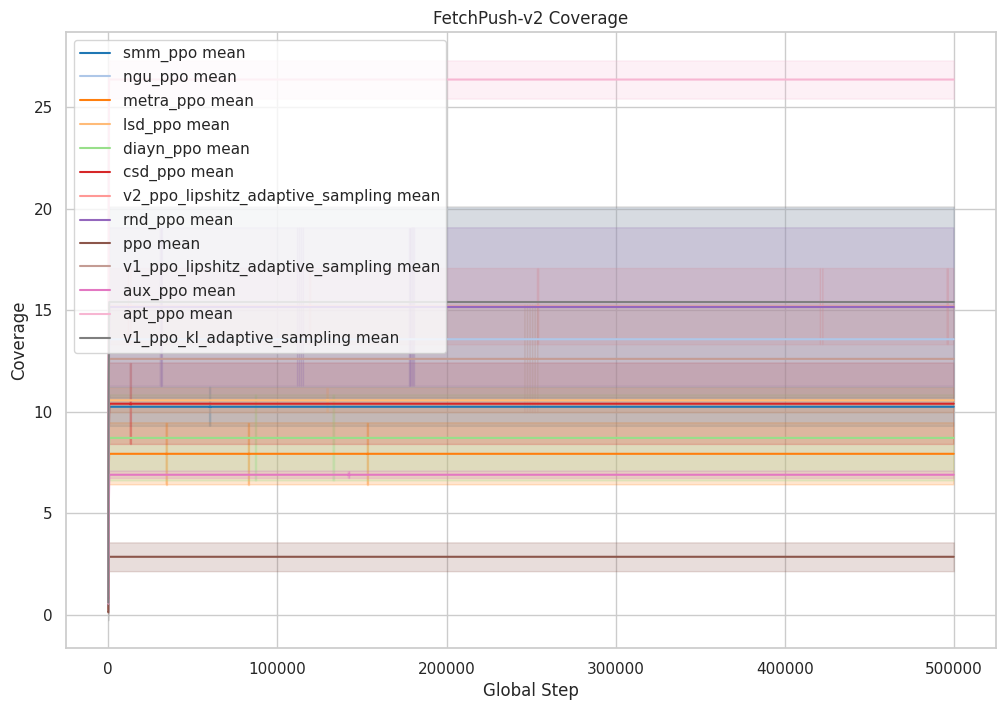

coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499827,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499825,)


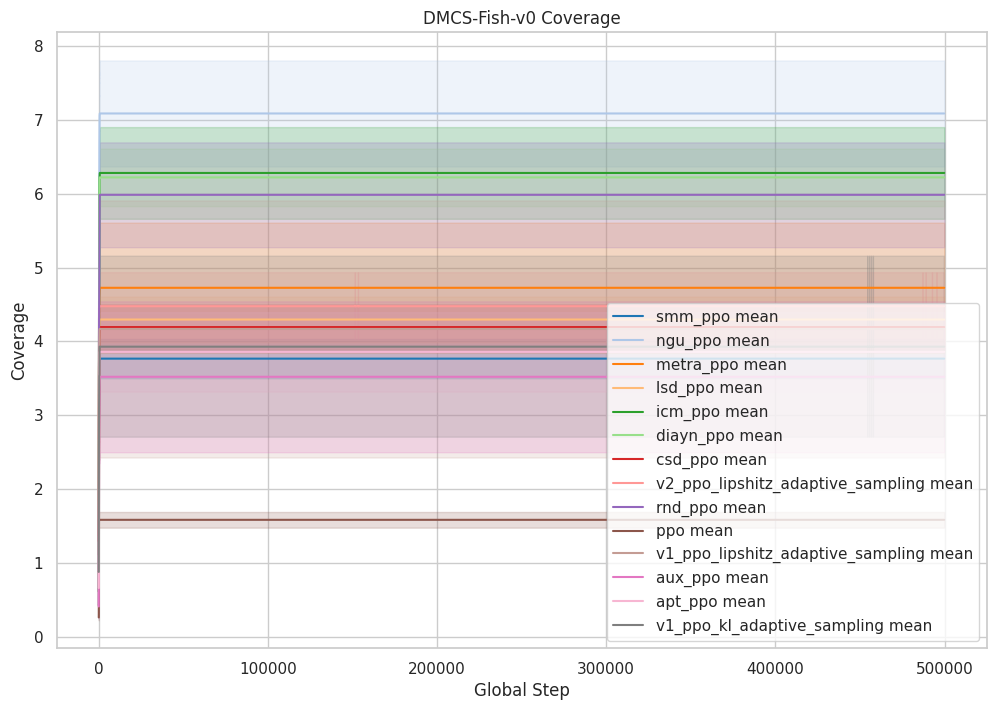

coverage mean shape (499745,)
coverage mean shape (499802,)
coverage mean shape (499745,)
coverage mean shape (499745,)
coverage mean shape (499815,)
coverage mean shape (499745,)
coverage mean shape (499745,)
coverage mean shape (499753,)
coverage mean shape (499804,)
coverage mean shape (499745,)
coverage mean shape (499833,)
coverage mean shape (499802,)
coverage mean shape (499800,)
coverage mean shape (499806,)


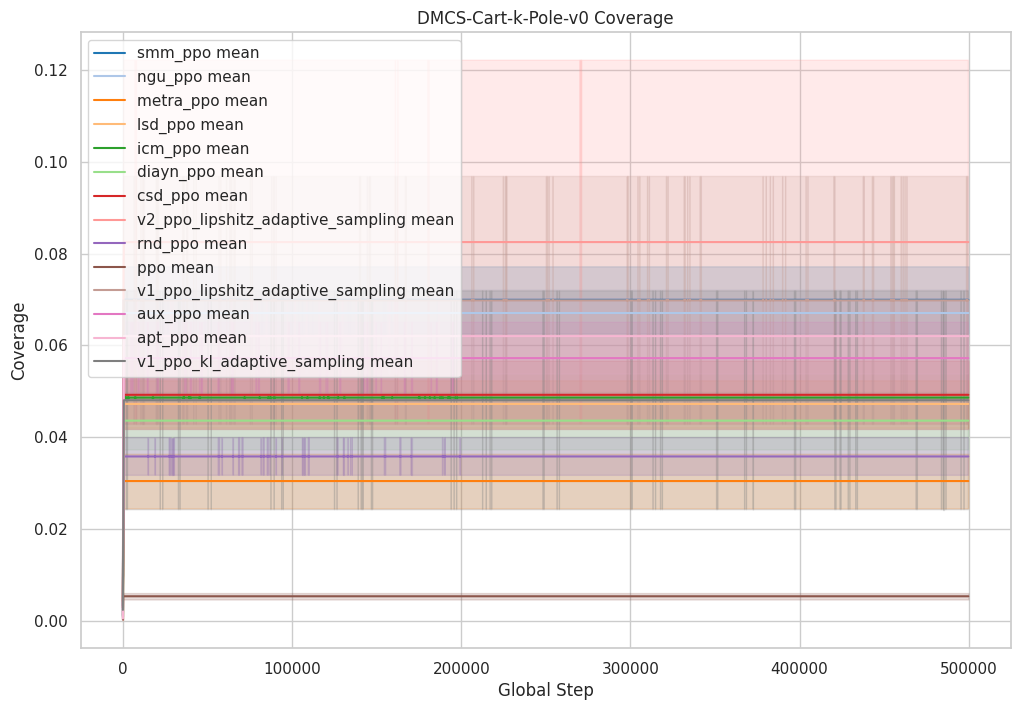

coverage mean shape (4999981,)
coverage mean shape (4999987,)
coverage mean shape (4999985,)
coverage mean shape (4999983,)
coverage mean shape (4999985,)
coverage mean shape (4999985,)
coverage mean shape (4999977,)
coverage mean shape (4999977,)
coverage mean shape (4999985,)
coverage mean shape (4999981,)
coverage mean shape (4999981,)
coverage mean shape (4999977,)


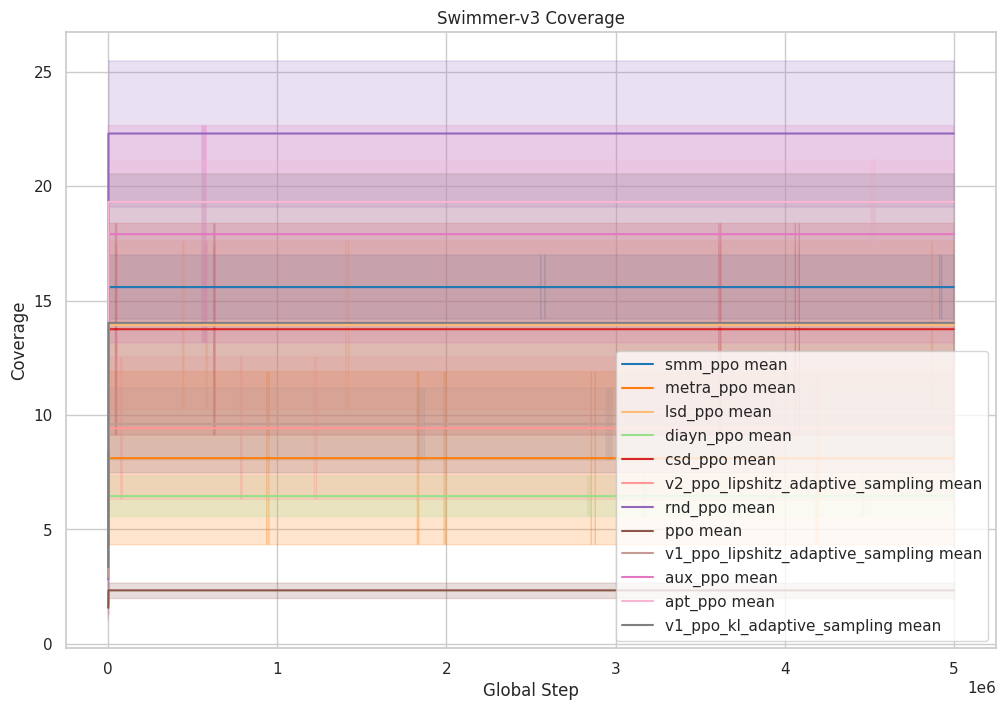

coverage mean shape (4999837,)
coverage mean shape (4999843,)
coverage mean shape (4999843,)
coverage mean shape (4999843,)
coverage mean shape (4999833,)
coverage mean shape (4999837,)


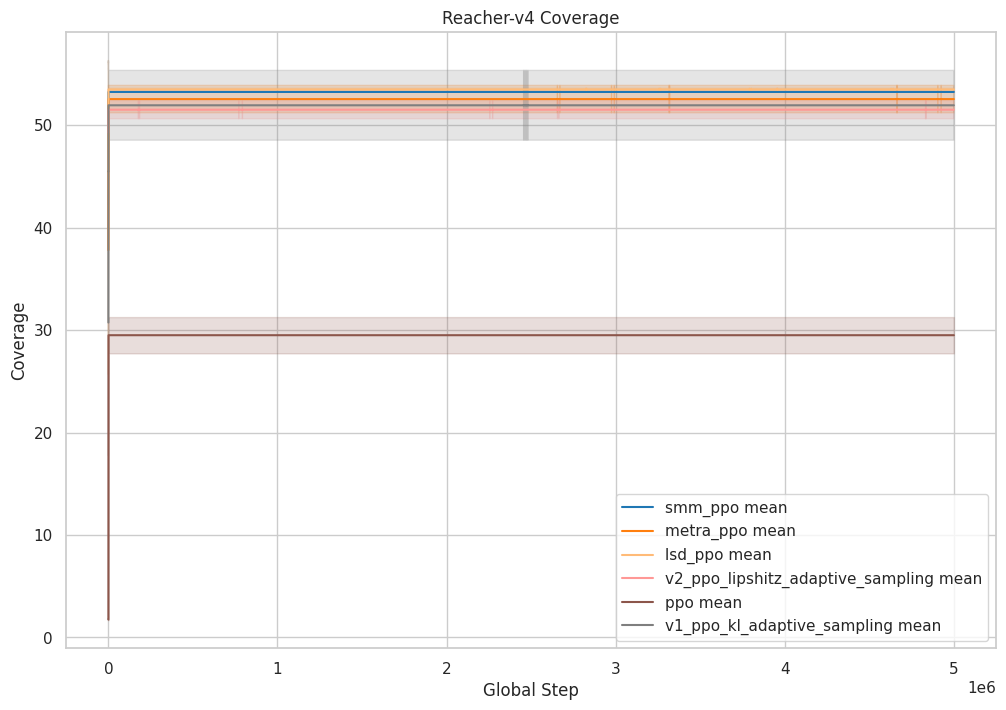

coverage mean shape (499799,)
coverage mean shape (499797,)
coverage mean shape (499803,)
coverage mean shape (499797,)
coverage mean shape (499801,)
coverage mean shape (499799,)
coverage mean shape (499805,)
coverage mean shape (499805,)
coverage mean shape (499797,)
coverage mean shape (499815,)
coverage mean shape (499801,)
coverage mean shape (499801,)
coverage mean shape (499809,)


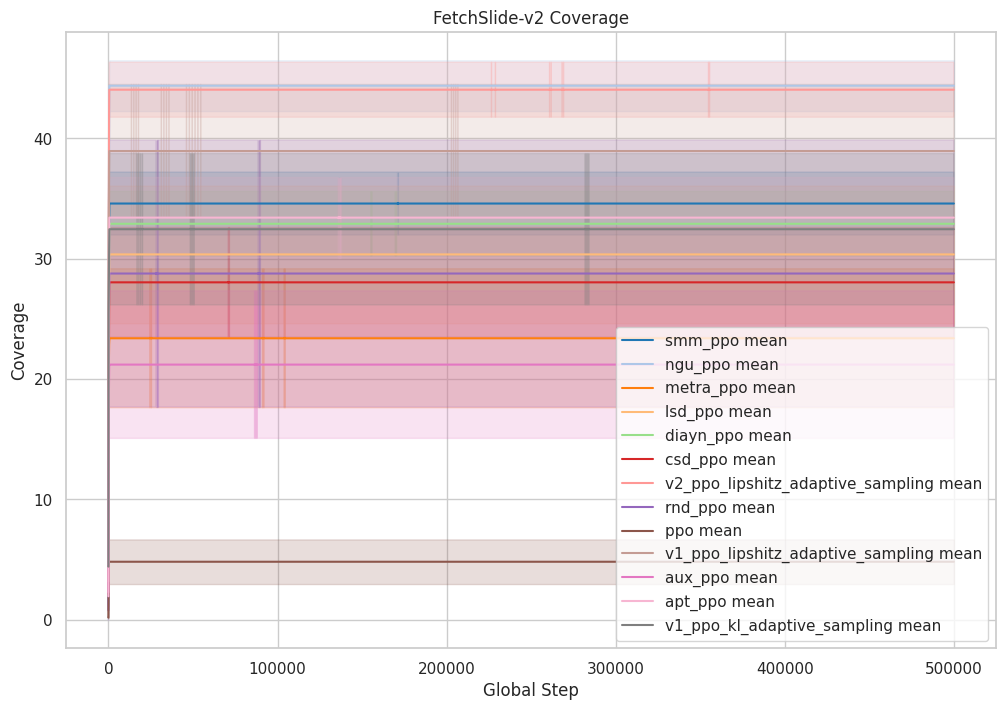

coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499823,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499825,)
coverage mean shape (499821,)
coverage mean shape (499821,)
coverage mean shape (499821,)


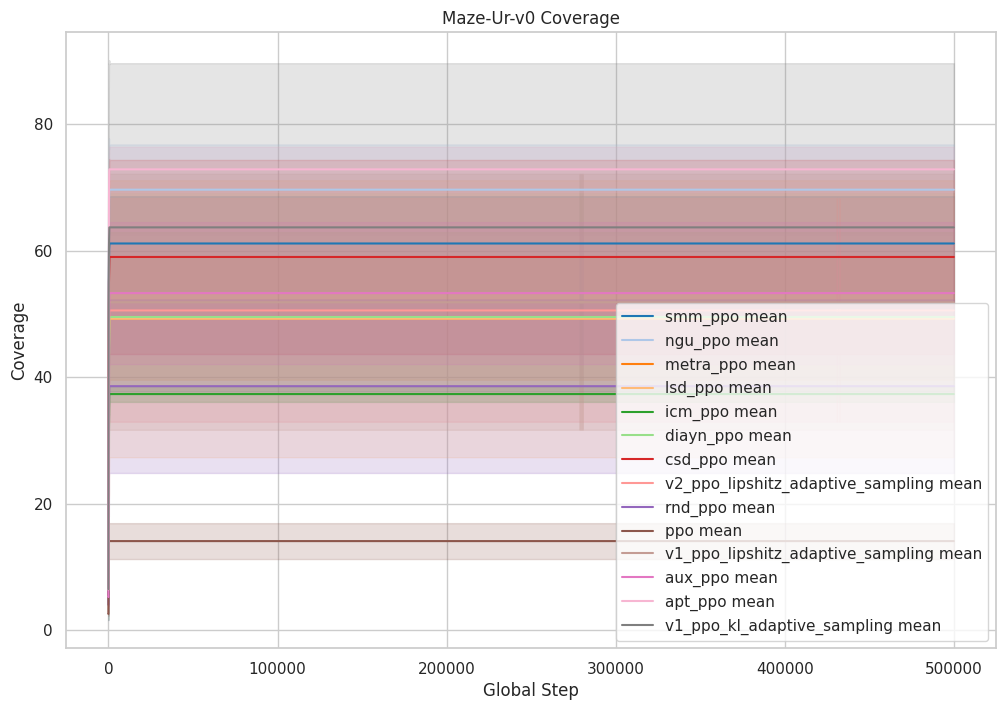

coverage mean shape (4996989,)
coverage mean shape (4996989,)
coverage mean shape (4996989,)
coverage mean shape (4996989,)
coverage mean shape (4996991,)
coverage mean shape (4996993,)
coverage mean shape (4996989,)
coverage mean shape (4996989,)
coverage mean shape (4997021,)
coverage mean shape (4997019,)
coverage mean shape (4996999,)


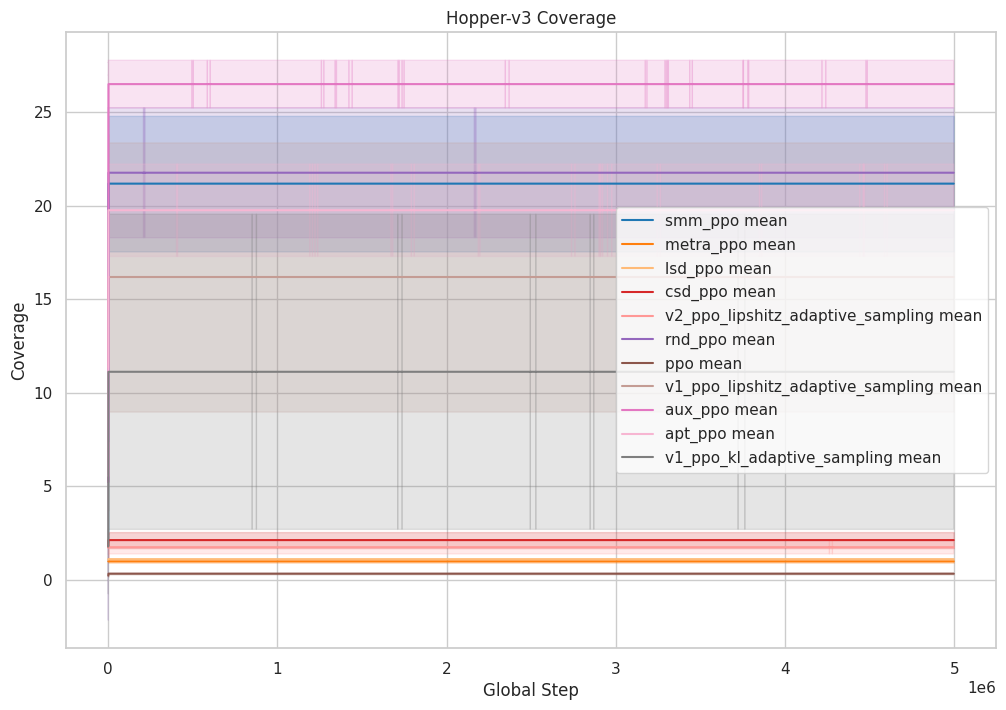

coverage mean shape (499745,)
coverage mean shape (499795,)
coverage mean shape (499745,)
coverage mean shape (499745,)
coverage mean shape (499798,)
coverage mean shape (499745,)
coverage mean shape (499745,)
coverage mean shape (499753,)
coverage mean shape (499798,)
coverage mean shape (499745,)
coverage mean shape (499820,)
coverage mean shape (499791,)
coverage mean shape (499810,)
coverage mean shape (499826,)


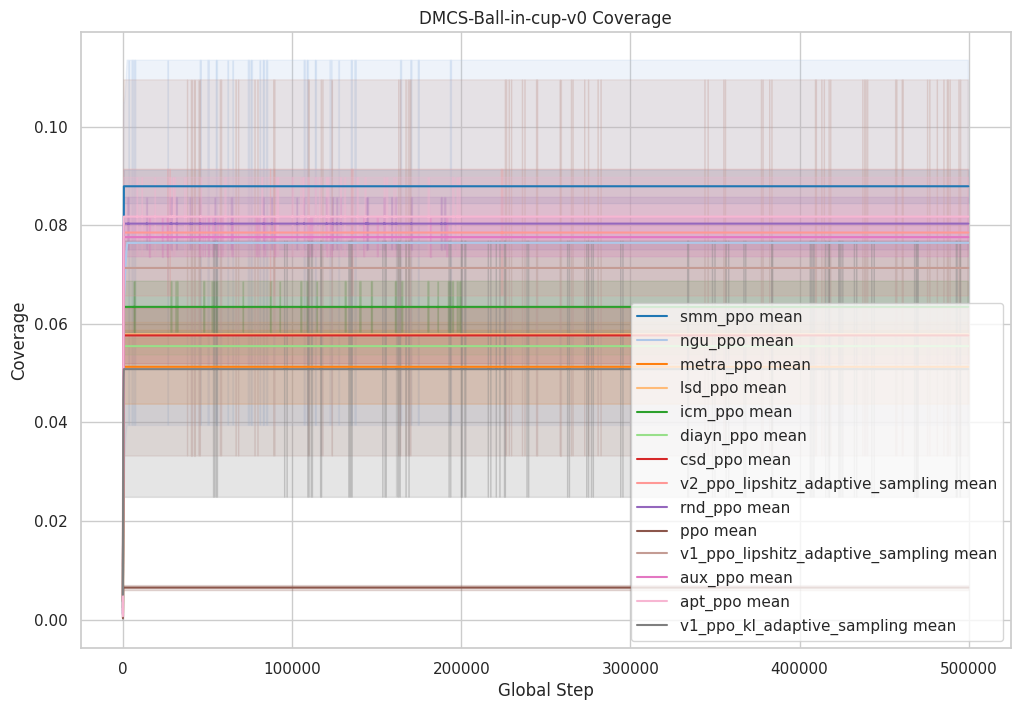

coverage mean shape (499809,)
coverage mean shape (499797,)
coverage mean shape (499799,)
coverage mean shape (499805,)
coverage mean shape (499805,)
coverage mean shape (499797,)
coverage mean shape (499803,)
coverage mean shape (499809,)
coverage mean shape (499797,)
coverage mean shape (499809,)
coverage mean shape (499797,)
coverage mean shape (499797,)
coverage mean shape (499797,)


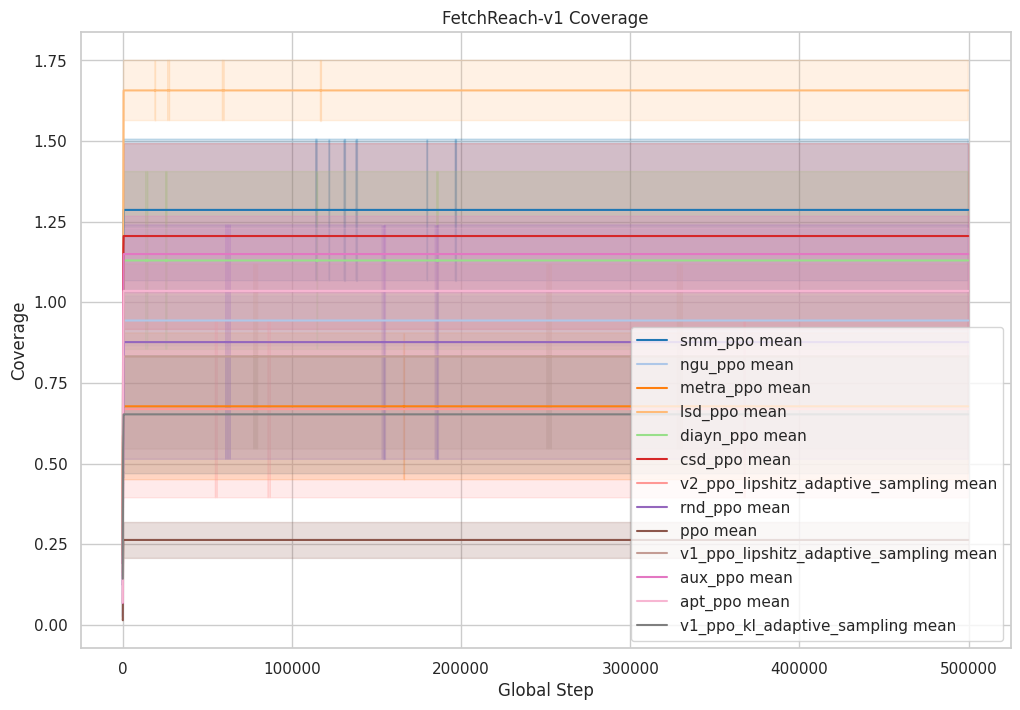

coverage mean shape (4996993,)
coverage mean shape (4997037,)
coverage mean shape (4996999,)
coverage mean shape (4996989,)
coverage mean shape (4996991,)
coverage mean shape (4996991,)
coverage mean shape (4996993,)
coverage mean shape (4997055,)
coverage mean shape (4996993,)
coverage mean shape (4996989,)
coverage mean shape (4997075,)
coverage mean shape (4997093,)
coverage mean shape (4997091,)
coverage mean shape (4997071,)


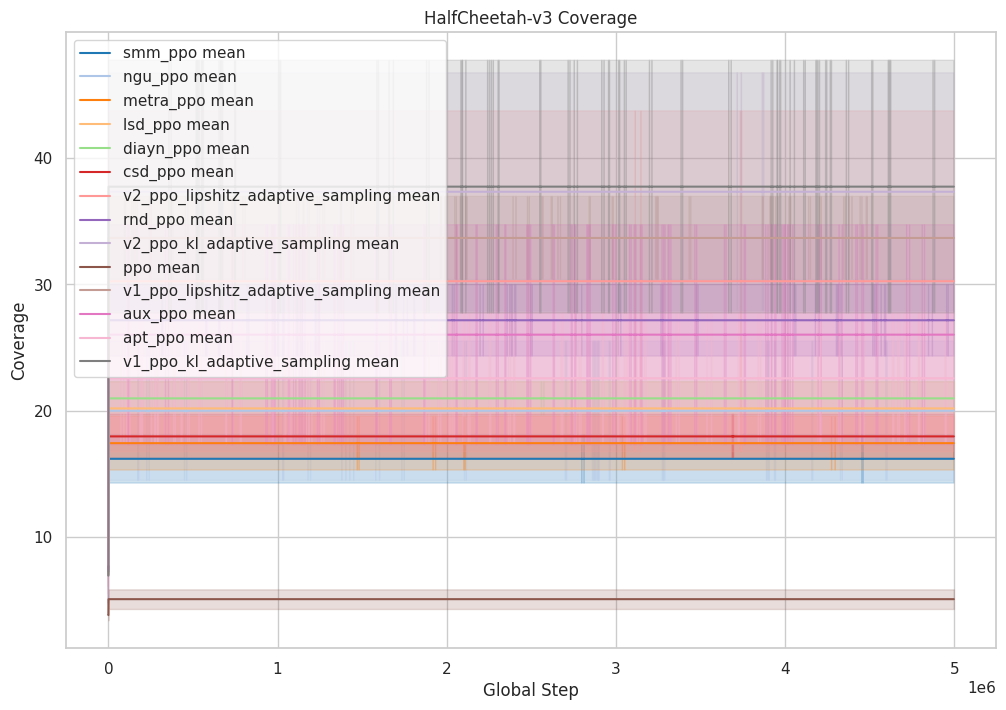

coverage mean shape (4996995,)
coverage mean shape (4997031,)
coverage mean shape (4996993,)
coverage mean shape (4996993,)
coverage mean shape (4996993,)
coverage mean shape (4996993,)
coverage mean shape (4996997,)
coverage mean shape (4996993,)
coverage mean shape (4996993,)
coverage mean shape (4996995,)
coverage mean shape (4996997,)
coverage mean shape (4996999,)
coverage mean shape (4997055,)


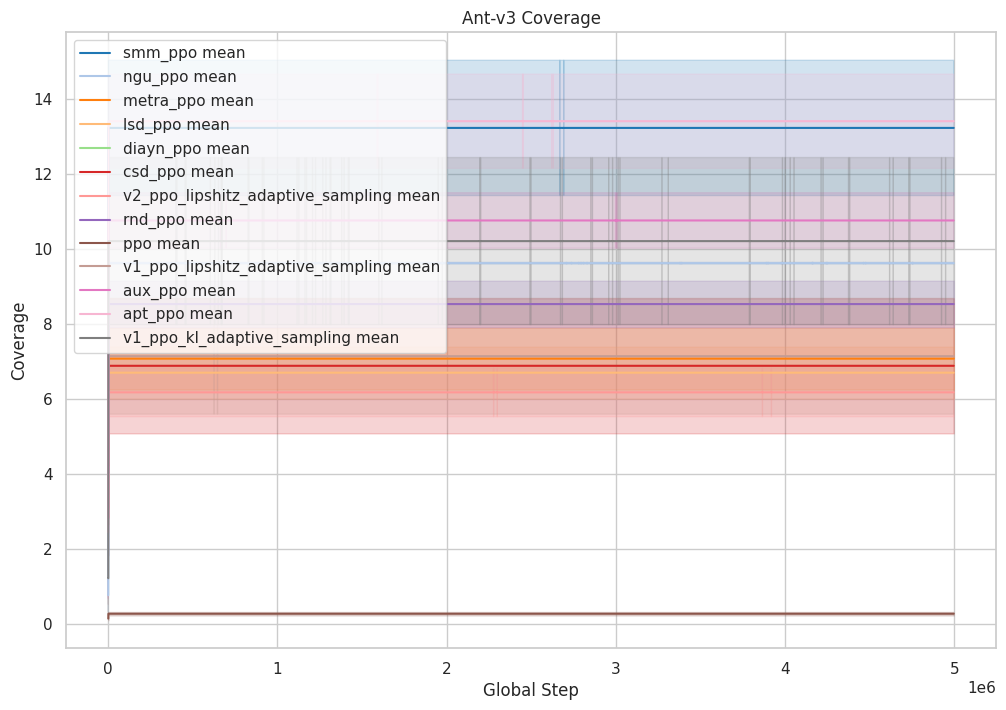

coverage mean shape (4996993,)
coverage mean shape (4996997,)
coverage mean shape (4996993,)
coverage mean shape (4996993,)
coverage mean shape (4996993,)
coverage mean shape (4996993,)
coverage mean shape (4997003,)
coverage mean shape (4996993,)
coverage mean shape (4997005,)
coverage mean shape (4997009,)
coverage mean shape (4997015,)
coverage mean shape (4997011,)


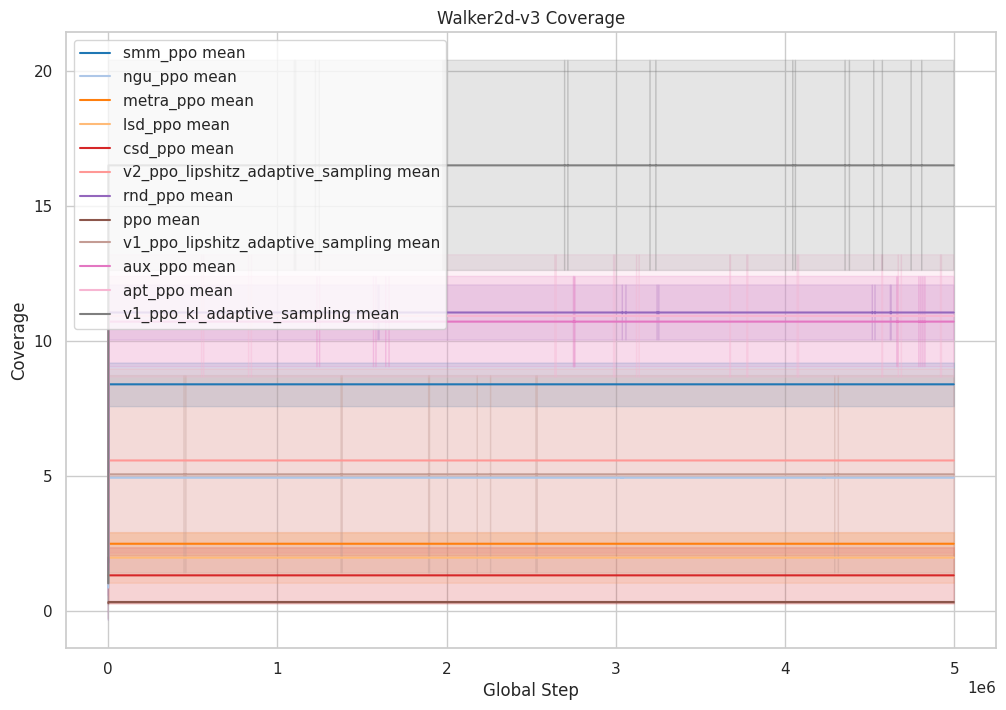

coverage mean shape (4996981,)
coverage mean shape (4996981,)
coverage mean shape (4996981,)
coverage mean shape (4996981,)


KeyboardInterrupt: 

In [5]:

# Déterminer les couleurs pour chaque algorithme
unique_exp_names = df['exp_name'].unique()
palette = plt.get_cmap("tab20").colors
color_map = {exp_name: palette[i % len(palette)] for i, exp_name in enumerate(unique_exp_names)}

# Plot pour chaque environnement
environments = df['env_name'].unique()

for env in environments:
    try:
        plt.figure(figsize=(12, 8))
        env_df = df[df['env_name'] == env]
        
        sns.set(style="whitegrid")
        for exp in env_df['exp_name'].unique():
            exp_df = env_df[env_df['exp_name'] == exp]
            # print('coverage mean shape', exp_df['coverage_mean'].shape)
            color = color_map[exp]
            plt.plot(exp_df['global_step'], exp_df['coverage_mean'], label=f'{exp} mean', color=color)
            plt.fill_between(exp_df['global_step'], 
                             exp_df['coverage_mean'] - exp_df['coverage_std'], 
                             exp_df['coverage_mean'] + exp_df['coverage_std'], 
                             alpha=0.2, color=color)
        
        plt.title(f'{env} Coverage')
        plt.xlabel('Global Step')
        plt.ylabel('Coverage')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Failed to plot for environment {env} due to: {e}")